In [1]:
# Content :

# Output will be shown. 
# Actual deployment model file uses Multinomial NB and all other models considered in this codebook will be dropped.
# This is so that run time will for actual deployment will be seamless.
# This codebook is strictly used for deciding which models to be used and for consideration only.

# Code that showcases data scrapped will be shown in a separate file titled "Scrape code"
# Code that creates the merged file will also be in separate file titled "Scrape code"

In [2]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score


# Make sure to download NLTK data if you haven't already:
# nltk.download('punkt')
# nltk.download('wordnet')


In [3]:
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw')

In [3]:
# The original "meat" & vegan" datasets is merged in a separate ipynb file titled "Scrape.ipynb"
# This codebook will feature heavily on modelling
merged_df = pd.read_csv("../data/merged_posts.csv")

In [4]:
# Checking if files are merged sucessfully
merged_df

,title,score,id,url,created,body,subreddit
0,What’s a good price for meats?,18,zowntt,https://www.reddit.com/r/meat/comments/zowntt/...,1.671363e+09,"I just recently moved to the US, specifically ...",meat
1,Why does the restaurant think this is Medium?,50,16o84am,https://i.redd.it/vrle578fvjpb1.jpg,1.695277e+09,NaN,meat
2,Why do deli hams flower like this when at thei...,11,16o8zfs,https://i.redd.it/ez2gndtg4kpb1.png,1.695280e+09,NaN,meat
3,Snake River Farms Wagyu Short Rib. Melts like ...,62,16n6emt,https://www.reddit.com/gallery/16n6emt,1.695168e+09,Only needs to kiss hot pan for a few seconds a...,meat
4,where do you guys get fat/tallow for cheap?,42,16mnurg,https://www.reddit.com/r/meat/comments/16mnurg...,1.695121e+09,My parents told me butchers used to throw away...,meat
...,...,...,...,...,...,...,...
5703,"48,000 PEOPLE WANT STARBUCKS TO STOP CHARGING ...",3275,ckyt4u,https://www.livekindly.com/starbucks-stop-char...,1.564717e+09,NaN,vegan
5704,When you see a non vegan recipe,3264,aksvtk,https://i.redd.it/j9uykvm9o8d21.jpg,1.548714e+09,NaN,vegan
5705,Isn’t Nature Beautiful?,3260,nr0iiv,https://i.redd.it/akyqn6c13y271.jpg,1.622680e+09,NaN,vegan
5706,We can come at y'all like that too!,3263,f5w5v5,https://i.redd.it/o4dr88np5qh41.jpg,1.582050e+09,NaN,vegan


In [5]:
# Converting texts to lowercase for a cleaner data which makes it easier to navigate within the df for further inspection.
# Removed punctuation as it serves no purpose at all for this analysis.
# Remove emojis as it serves no purpose at all for this analysis.

# Function to clean text data, handling NaN and non-string types
def clean_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuations
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [6]:
# Applying the cleaning function to the 'title' and 'body' columns of merged dataframe
merged_df['title'] = merged_df['title'].apply(clean_text)
merged_df['body'] = merged_df['body'].apply(clean_text)

In [7]:
# All text to lowercase, No emojis, No punctuations
# Checking if it is indeed applied
merged_df

,title,score,id,url,created,body,subreddit
0,whats a good price for meats,18,zowntt,https://www.reddit.com/r/meat/comments/zowntt/...,1.671363e+09,i just recently moved to the us specifically i...,meat
1,why does the restaurant think this is medium,50,16o84am,https://i.redd.it/vrle578fvjpb1.jpg,1.695277e+09,,meat
2,why do deli hams flower like this when at thei...,11,16o8zfs,https://i.redd.it/ez2gndtg4kpb1.png,1.695280e+09,,meat
3,snake river farms wagyu short rib melts like b...,62,16n6emt,https://www.reddit.com/gallery/16n6emt,1.695168e+09,only needs to kiss hot pan for a few seconds a...,meat
4,where do you guys get fattallow for cheap,42,16mnurg,https://www.reddit.com/r/meat/comments/16mnurg...,1.695121e+09,my parents told me butchers used to throw away...,meat
...,...,...,...,...,...,...,...
5703,48000 people want starbucks to stop charging e...,3275,ckyt4u,https://www.livekindly.com/starbucks-stop-char...,1.564717e+09,,vegan
5704,when you see a non vegan recipe,3264,aksvtk,https://i.redd.it/j9uykvm9o8d21.jpg,1.548714e+09,,vegan
5705,isnt nature beautiful,3260,nr0iiv,https://i.redd.it/akyqn6c13y271.jpg,1.622680e+09,,vegan
5706,we can come at yall like that too,3263,f5w5v5,https://i.redd.it/o4dr88np5qh41.jpg,1.582050e+09,,vegan


In [9]:
# Dropping "Score", "id", "url", "created" as it serves no purpose
# The values listed in aforementioned columns has no impact in this analysis

columns_to_drop = ['id', 'url', 'created', 'score']  # Replace these with the actual column names you want to drop
merged_df.drop(columns=columns_to_drop, inplace=True)

In [10]:
# Check if columns are dropped
merged_df

,title,body,subreddit
0,whats a good price for meats,i just recently moved to the us specifically i...,meat
1,why does the restaurant think this is medium,,meat
2,why do deli hams flower like this when at thei...,,meat
3,snake river farms wagyu short rib melts like b...,only needs to kiss hot pan for a few seconds a...,meat
4,where do you guys get fattallow for cheap,my parents told me butchers used to throw away...,meat
...,...,...,...
5703,48000 people want starbucks to stop charging e...,,vegan
5704,when you see a non vegan recipe,,vegan
5705,isnt nature beautiful,,vegan
5706,we can come at yall like that too,,vegan


In [11]:
# Drop rows where both 'title' and 'body' are empty
# Doing this because certain posts contains pictures and is therefore not helpful to the analysis
merged_df.dropna(subset=['title', 'body'], how='all', inplace=True)

# Drop rows where 'title' or 'body' are likely just URLs or very short text
# This can be done by checking the length of the content
min_text_length = 10  # You can adjust this threshold based on your data
merged_df = merged_df[merged_df['title'].str.len() > min_text_length]
merged_df = merged_df[merged_df['body'].str.len() > min_text_length]

# Reset the index after dropping rows
merged_df.reset_index(drop=True, inplace=True)

In [12]:
# Display the updated shape of the DataFrame to see how many rows remain
merged_df.shape

(1763, 3)

In [13]:
# Checking numbers of posts per subreddit.
subreddit_counts = merged_df['subreddit'].value_counts()
subreddit_counts

vegan    1250
meat      513
Name: subreddit, dtype: int64

In [14]:
# Combine 'title' and 'body' into a single 'text' column
merged_df['text'] = merged_df['title'] + ' ' + merged_df['body']

# Remove all numbers from the 'text' column
merged_df['text'] = merged_df['text'].apply(lambda x: re.sub(r'\d+', '', x))

In [15]:
# 1.1 :We're doing this because we want to upscale meat's post.count to potentially match vegan's post.count
# 1.2 : This is so that the machine will have equal oppoturnities to train on both subreddits (meat,vegan)

# Used an imblearn pipeline instead of a normal pipeline because -
# its built specifically to integrate resampling techniques (like SMOTE) into the pipeline
# ****** SMOTE is not applied to test ******

# Convert text data into numerical format using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(merged_df['text'])

# Encode the 'subreddit' column
le = LabelEncoder()
y = le.fit_transform(merged_df['subreddit'])

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Define pipelines with SMOTE and classifiers
pipelines = {
    "Logistic Regression": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', LogisticRegression())
    ]),
    "Multinomial Naive Bayes": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', MultinomialNB())
    ]),
    "Bernoulli Naive Bayes": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', BernoulliNB())
    ]),
    "Gaussian Naive Bayes": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),  # Convert sparse matrix to dense
        ('classifier', GaussianNB())
    ]),
    "Random Forest": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', RandomForestClassifier(random_state=2))
    ]),
    "XGBoost": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=2))
    ])
}

# Fit the pipelines using training data and evaluate them using the test data
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)
    
    print(f"{name}:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("-" * 40)

Logistic Regression:
Training Accuracy: 0.9957
Test Accuracy: 0.9688
----------------------------------------
Multinomial Naive Bayes:
Training Accuracy: 0.9851
Test Accuracy: 0.9717
----------------------------------------
Bernoulli Naive Bayes:
Training Accuracy: 0.8801
Test Accuracy: 0.8499
----------------------------------------
Gaussian Naive Bayes:
Training Accuracy: 0.9858
Test Accuracy: 0.8612
----------------------------------------
Random Forest:
Training Accuracy: 1.0000
Test Accuracy: 0.9575
----------------------------------------
XGBoost:
Training Accuracy: 0.9972
Test Accuracy: 0.9490
----------------------------------------


In [16]:
# After initial testing, Gaussian NB and Bernoulli NB had the lowest scores.
# We'd be using Bernoulli NB as our baseline to beat as it is the worst performing model
# Models with an accuracy over 90% will be sent for hyperparameter tuning to see if we can improve the model further

# Tuning the hyper parameters of the top 3 models to see if we get a better score.

pipelines = {
    "Logistic Regression": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', LogisticRegression())
    ]),
    "Multinomial Naive Bayes": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', MultinomialNB())
    ]),
    "Random Forest": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', RandomForestClassifier(random_state=2))
    ]),
    "XGBoost": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=2))
    ]),
    "Bernoulli Naive Bayes": ImbPipeline([
        ('smote', SMOTE(random_state=2)),
        ('classifier', BernoulliNB())
    ])
}

param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.1, 1, 10]
    },
    "Multinomial Naive Bayes": {
        'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
    },
    "Random Forest": {
        'classifier__n_estimators': [50, 100, 150],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    "XGBoost": {
        'classifier__learning_rate': [0.01, 0.1, 0.5],
        'classifier__n_estimators': [50, 100, 150],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0]
    },
    "Bernoulli Naive Bayes": {
        'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
    }
}

# Hyperparameter tuning for each classifier
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5)
    grid_search.fit(X_train, y_train)
    
    best_cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    
    print(f"{name}:")
    print(f"Best CV Score: {best_cv_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print("-" * 40)

Logistic Regression:
Best CV Score: 0.9617
Test Score: 0.9688
----------------------------------------
Multinomial Naive Bayes:
Best CV Score: 0.9567
Test Score: 0.9717
----------------------------------------
Random Forest:
Best CV Score: 0.9489
Test Score: 0.9660
----------------------------------------
XGBoost:
Best CV Score: 0.9305
Test Score: 0.9462
----------------------------------------
Bernoulli Naive Bayes:
Best CV Score: 0.9057
Test Score: 0.9178
----------------------------------------


In [17]:
# Random forest's & XGBoost's line will take some time to run but in general, these are the scores

# LR : CV - 0.9617 ---------- Test - 0.9688
# MNB : CV - 0.9567 --------- Test - 0.9717
# RF : CV - 0.9489 ---------- Test - 0.9660
# XGB : CV - 0.9305 --------- Test - 0.9462
# BNB : Cv - 0.9057 --------- Test - 0.9178

# Multinomial Naive Bayes will be used for deployment.

In [18]:
# Getting the various scores for all the models in consideration

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # For ROC-AUC, we need probability estimates of the positive class
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"{name}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("-" * 40)

Logistic Regression:
Precision: 0.9691
Recall: 0.9882
F1 Score: 0.9786
ROC-AUC: 0.9922
----------------------------------------
Multinomial Naive Bayes:
Precision: 0.9729
Recall: 0.9882
F1 Score: 0.9805
ROC-AUC: 0.9904
----------------------------------------
Random Forest:
Precision: 0.9650
Recall: 0.9764
F1 Score: 0.9706
ROC-AUC: 0.9921
----------------------------------------
XGBoost:
Precision: 0.9646
Recall: 0.9646
F1 Score: 0.9646
ROC-AUC: 0.9864
----------------------------------------
Bernoulli Naive Bayes:
Precision: 0.9902
Recall: 0.7992
F1 Score: 0.8845
ROC-AUC: 0.9881
----------------------------------------


In [19]:
# Tuning hyperparameters for the other scores.
results = {}  # Store results for later comparison if needed

# Hyperparameter tuning and then evaluating metrics
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5)
    grid_search.fit(X_train, y_train)
    
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # For ROC-AUC, we need probability estimates of the positive class
    y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc
    }
    
    print(f"{name}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("-" * 40)

Logistic Regression:
Precision: 0.9691
Recall: 0.9882
F1 Score: 0.9786
ROC-AUC: 0.9922
----------------------------------------
Multinomial Naive Bayes:
Precision: 0.9729
Recall: 0.9882
F1 Score: 0.9805
ROC-AUC: 0.9906
----------------------------------------
Random Forest:
Precision: 0.9802
Recall: 0.9724
F1 Score: 0.9763
ROC-AUC: 0.9927
----------------------------------------
XGBoost:
Precision: 0.9719
Recall: 0.9528
F1 Score: 0.9622
ROC-AUC: 0.9878
----------------------------------------
Bernoulli Naive Bayes:
Precision: 0.9747
Recall: 0.9094
F1 Score: 0.9409
ROC-AUC: 0.9827
----------------------------------------


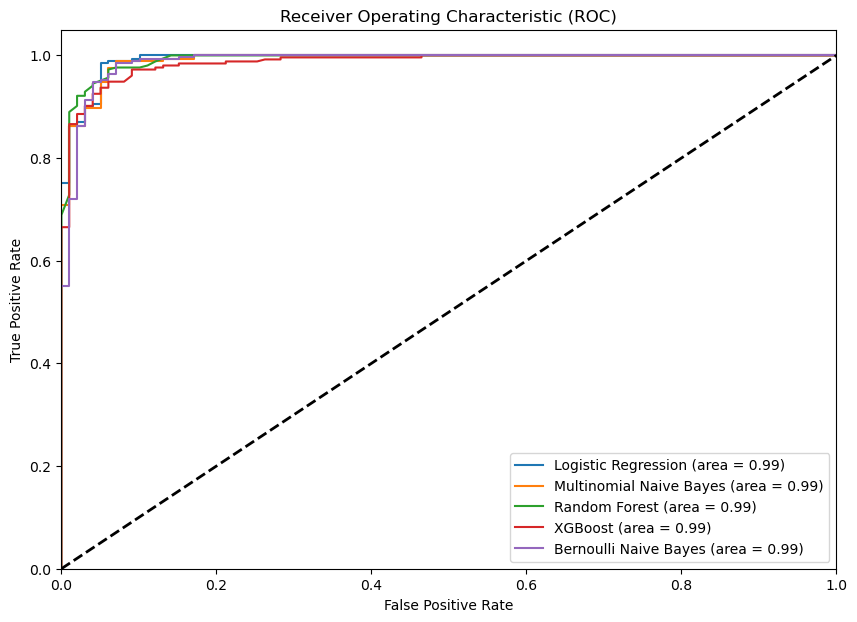

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Fit the pipelines and plot ROC-AUC without tuning
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    
    # Get the probability estimates of the positive class
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and ROC area for each model
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plotting the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

# Plotting the random classifier (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


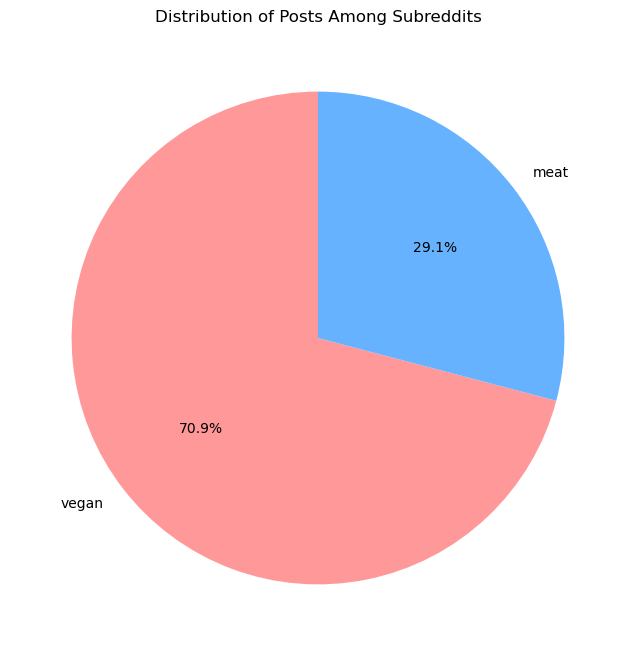

In [21]:
# Extracting subreddit names and their counts
subreddit_labels = subreddit_counts.index
subreddit_sizes = subreddit_counts.values

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(subreddit_sizes, labels=subreddit_labels, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF'])
plt.title('Distribution of Posts Among Subreddits')
plt.show()
